# Aug 24, Sep 23, 2025: model comparison
using `total evidence, L` of a model per chain

conda env: gt

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from scipy.stats import wilcoxon, ttest_rel
from statsmodels.stats.multitest import multipletests
from multiprocessing import Pool
import glob
import random
import re

# import arviz as az

from itertools import product, combinations
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

def setup_plotting(palette=None, context="paper", fontsize=7):
    """
    Configure seaborn with 'paper' context and synced matplotlib rcParams.
    """
    setup_mpl(fontsize)

    if palette is None:
        try:
            from cycler import cycler
            cycle = mpl.rcParams['axes.prop_cycle']
            palette = [d['color'] for d in cycle]
        except Exception:
            palette = sns.color_palette("colorblind")

    sns.set_theme(
        context=context,       # use "paper"
        style="white", 
        palette=palette, 
        rc=mpl.rcParams
    )

    setup_mpl(fontsize)

In [3]:
# setup_plotting(context='paper', fontsize=7)
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

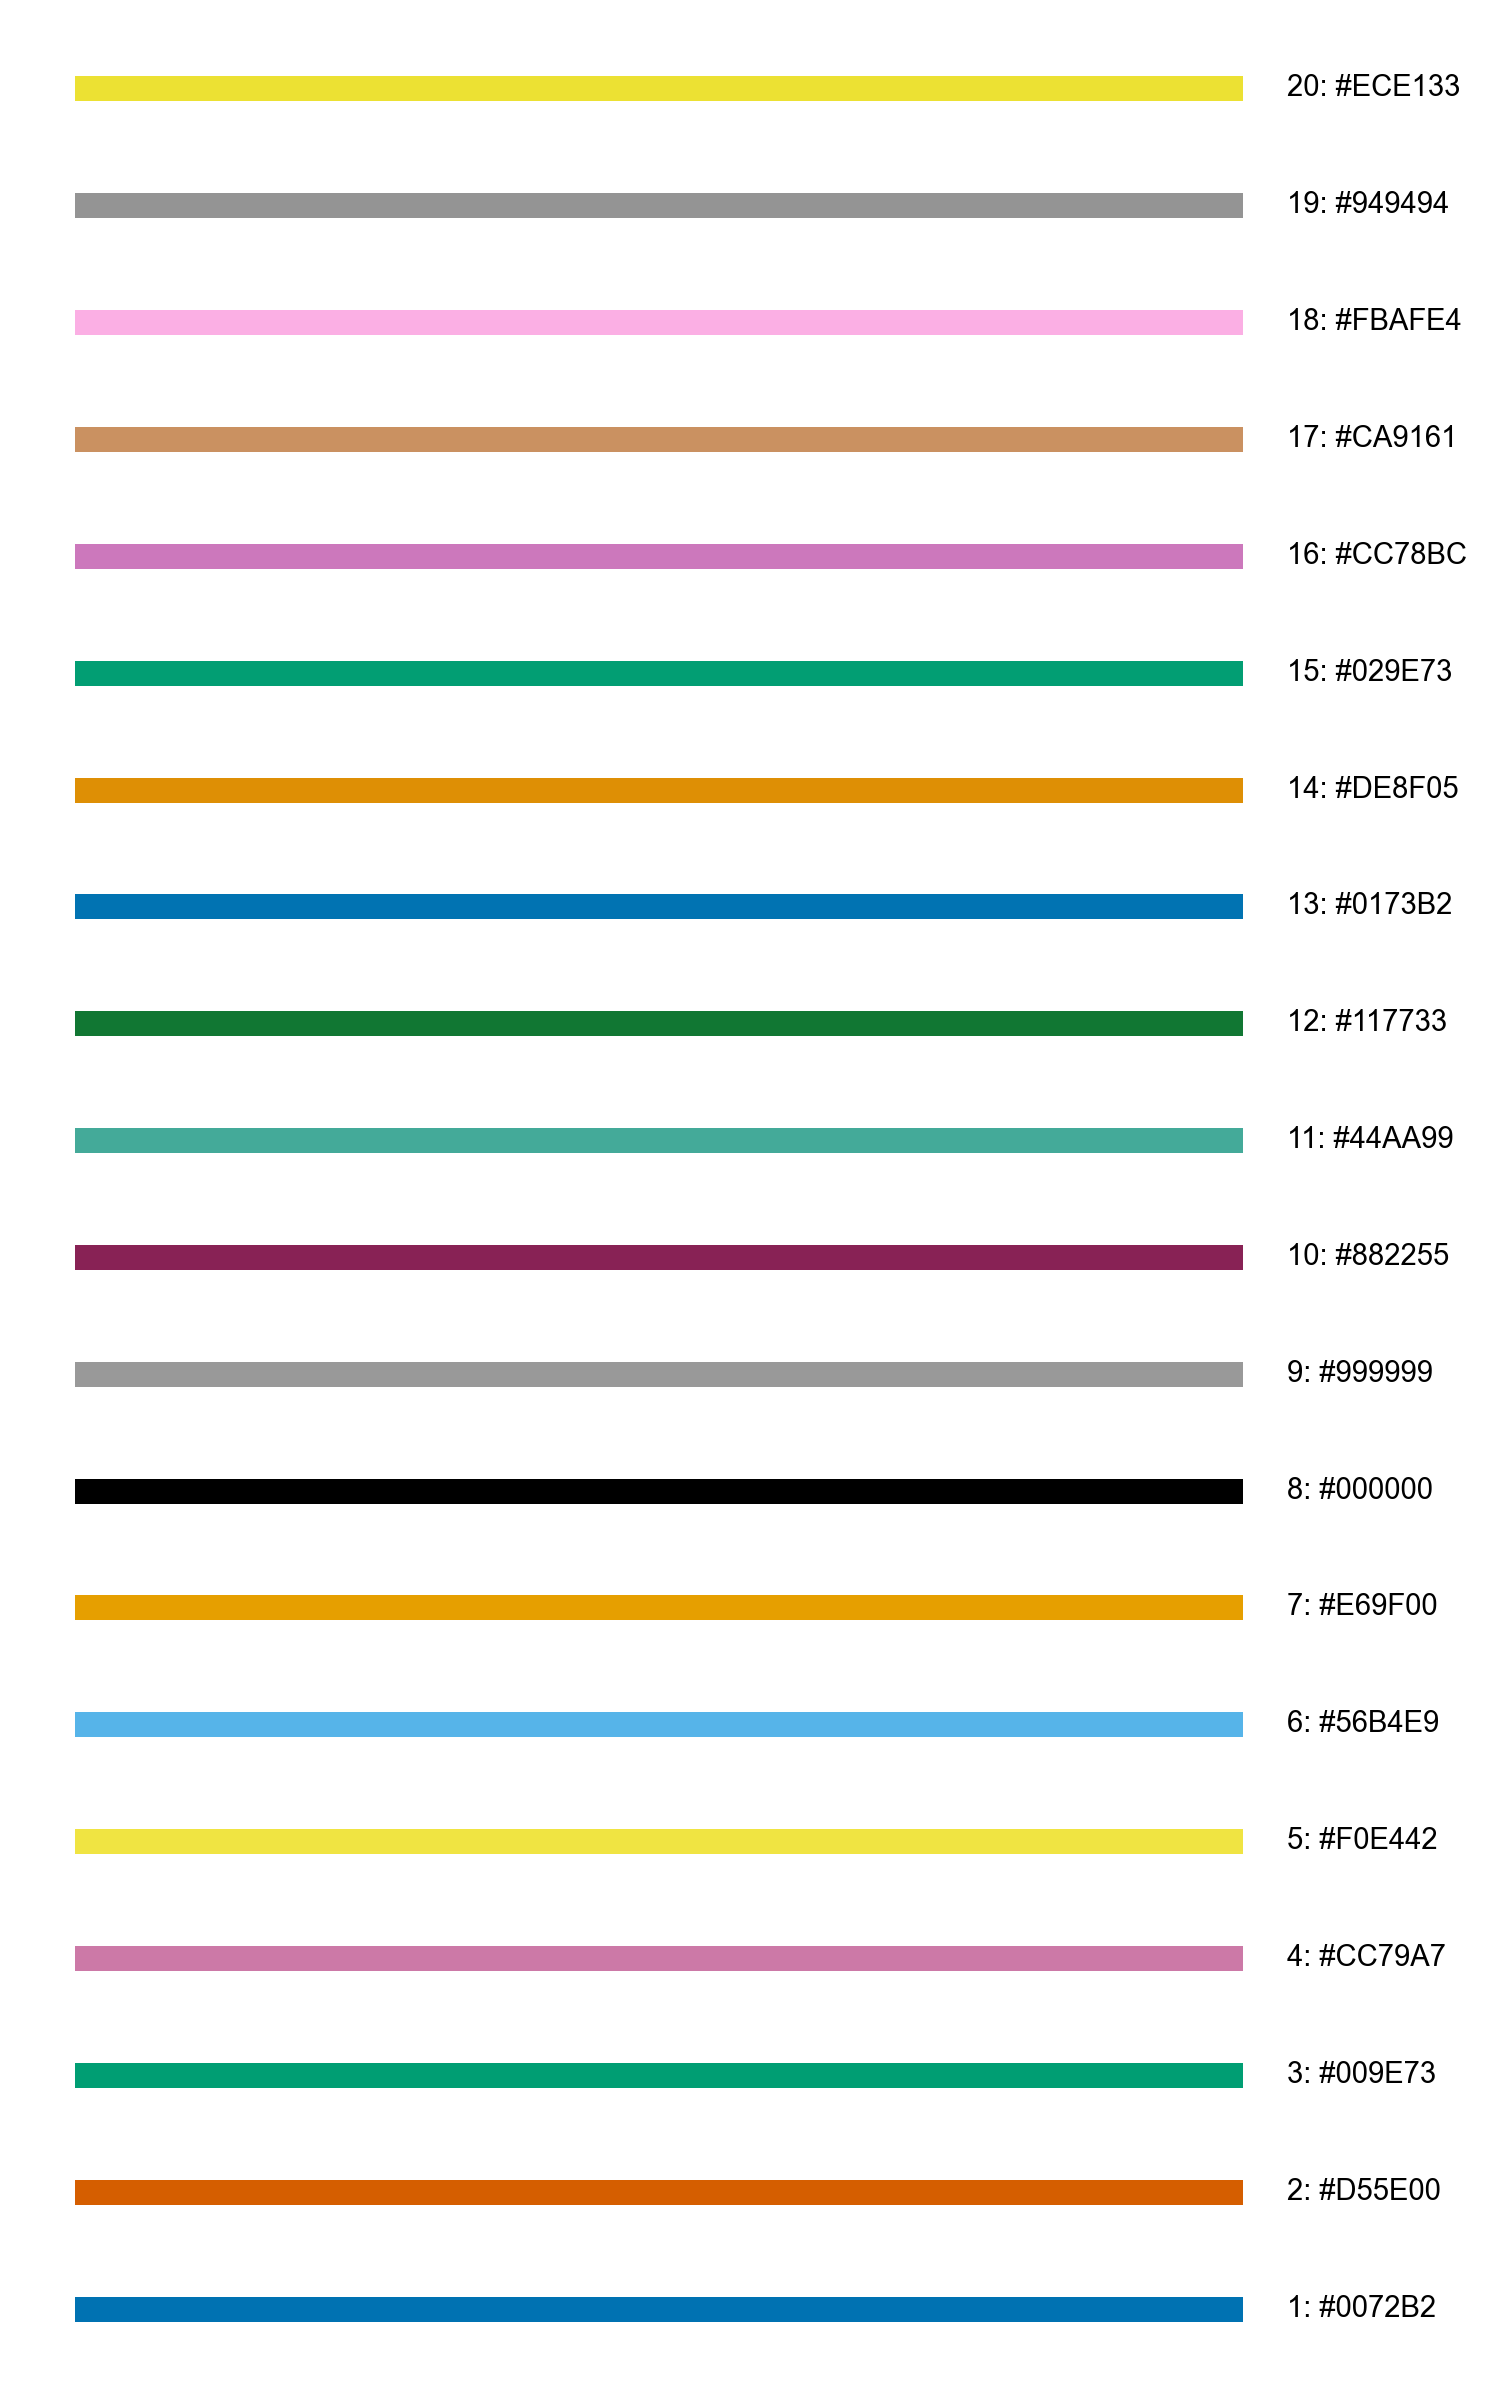

In [4]:
def preview_colorblind_palette():
    colors = get_colorblind_palette()
    n = len(colors)
    
    fig, ax = plt.subplots(figsize=(5, 0.4 * n))
    for i, color in enumerate(colors):
        ax.plot([0, 1], [i, i], color=color, linewidth=6)
        ax.text(1.05, i, f"{i+1}: {color}", va='center', ha='left', fontsize=7)
    
    ax.set_ylim(-0.5, n - 0.5)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
preview_colorblind_palette()

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [6]:
args.source = 'allen'
args.space = 'ccfv2'
args.brain_div = 'whl'
args.num_rois = 172
args.resolution = 200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [7]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'l1o'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)

In [8]:
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [9]:
main_folders = sorted(glob.glob(f'{SBM_path}/*', recursive=True))
main_folders

['/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-l1o/model-fits/sub-SLC01_task-rest',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-l1o/model-fits/sub-SLC03_task-rest',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-l1o/model-fits/sub-SLC04_task-rest',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-l1o/model-fits/sub-SLC05_task-rest',
 '/home/govindas/new_mouse_dataset/roi-results-v

In [10]:
def collect_evidence_files(args, evidence_files):
    ldf = []
    for file in evidence_files:
        pattern = r"sub-(?P<sub>[^_]+).*?/sbm-(?P<sbm>[^/]+)/B-(?P<B>\d+)"
        match = re.search(pattern, file)
        if match:
            sub, sbm, B = match.groups()
            
        if sbm == '-m': continue
        
        with open(file, 'rb') as f:
            [L] = pickle.load(f)

        row = pd.DataFrame(dict(
            sub=[sub],
            sbm=[sbm],
            B=[B],
            L=[-L], #flipping sign to make log evidence into total description length
        ))
        ldf += [row]
    ldf = pd.concat(ldf).reset_index(drop=True) 
    # pdf = ldf.pivot(index='B', columns=['sub', 'sbm'], values='L')
    return ldf

In [11]:
evidence_files = sorted(glob.glob(f'{SBM_path}/*/sbm-*/B-*/desc-evidence.pkl'))
ldf = collect_evidence_files(args, evidence_files)

In [12]:
ldf

,sub,sbm,B,L
0,SLC01,-a,1,6675.613589
1,SLC01,-a,112,6675.770565
2,SLC01,-a,224,6675.902110
3,SLC01,-a,335,6675.785572
4,SLC01,-a,446,6678.259785
...,...,...,...,...
309,SLC10,nd-o,1,6081.664623
310,SLC10,nd-o,112,6078.680121
311,SLC10,nd-o,224,6083.622960
312,SLC10,nd-o,335,6079.475866


In [13]:
main_df = ldf.groupby(by=['sub', 'sbm'])['L'].median().reset_index()
main_df

,sub,sbm,L
0,SLC01,-a,6675.785572
1,SLC01,dc-d,5924.086489
2,SLC01,dc-h,5785.246489
3,SLC01,dc-o,6124.739326
4,SLC01,nd-d,5757.492514
...,...,...,...
58,SLC10,dc-h,5831.147574
59,SLC10,dc-o,6192.894729
60,SLC10,nd-d,5812.561786
61,SLC10,nd-h,5665.155839


In [14]:
main_df = main_df.pivot(index='sub', columns='sbm', values='L')
main_df = main_df.interpolate() # to avoid missing values and get going
main_df

sbm,-a,dc-d,dc-h,dc-o,nd-d,nd-h,nd-o
sub,,,,,,,
SLC01,6675.785572,5924.086489,5785.246489,6124.739326,5757.492514,5618.163049,6012.894660
SLC03,6681.602500,5956.031042,5812.477428,6156.575384,5791.621099,5634.797806,6038.054247
SLC04,6645.656721,5918.293030,5791.007956,6117.418097,5752.737131,5611.303757,5999.509468
SLC05,6725.174688,5971.174974,5824.871556,6174.456993,5804.826715,5655.403630,6064.312371
SLC06,6731.301160,5978.177717,5849.839737,6191.517273,5816.252416,5679.988694,6084.337018
SLC07,6778.421221,5975.801240,5831.421222,6188.483471,5802.686483,5657.787810,6070.026192
SLC08,6706.137885,5956.233559,5804.809193,6166.250185,5795.610236,5643.817169,6059.232817
SLC09,6708.705376,5957.903330,5817.869072,6163.606251,5788.794583,5646.461804,6044.331525
SLC10,6766.790481,5977.426837,5831.147574,6192.894729,5812.561786,5665.155839,6081.354285


In [15]:
def sort_sbms(pdf):
    rank_df = pdf.rank(axis=1, method='min', ascending=True)
    modal_ranks = stats.mode(rank_df.to_numpy(), axis=0).mode
    cols_sorted = [col for _, col in sorted(zip(modal_ranks, pdf.columns))]
    return pdf[cols_sorted]

In [16]:
main_df = sort_sbms(main_df)
main_df = main_df.reset_index()
main_df

sbm,sub,nd-h,nd-d,dc-h,dc-d,nd-o,dc-o,-a
0,SLC01,5618.163049,5757.492514,5785.246489,5924.086489,6012.894660,6124.739326,6675.785572
1,SLC03,5634.797806,5791.621099,5812.477428,5956.031042,6038.054247,6156.575384,6681.602500
2,SLC04,5611.303757,5752.737131,5791.007956,5918.293030,5999.509468,6117.418097,6645.656721
3,SLC05,5655.403630,5804.826715,5824.871556,5971.174974,6064.312371,6174.456993,6725.174688
4,SLC06,5679.988694,5816.252416,5849.839737,5978.177717,6084.337018,6191.517273,6731.301160
5,SLC07,5657.787810,5802.686483,5831.421222,5975.801240,6070.026192,6188.483471,6778.421221
6,SLC08,5643.817169,5795.610236,5804.809193,5956.233559,6059.232817,6166.250185,6706.137885
7,SLC09,5646.461804,5788.794583,5817.869072,5957.903330,6044.331525,6163.606251,6708.705376
8,SLC10,5665.155839,5812.561786,5831.147574,5977.426837,6081.354285,6192.894729,6766.790481


In [17]:
main_df = main_df.rename(columns={'nd-d': 'nd-s', 'dc-d': 'dc-s'})

---

In [18]:
df = main_df
id_vars = ['sub']
model_cols = [col for col in df.columns if col not in id_vars]
long_df = df.melt(
    id_vars=id_vars,
    value_vars=model_cols,
    var_name='model',
    value_name='dl',
)
long_df

,sub,model,dl
0,SLC01,nd-h,5618.163049
1,SLC03,nd-h,5634.797806
2,SLC04,nd-h,5611.303757
3,SLC05,nd-h,5655.403630
4,SLC06,nd-h,5679.988694
...,...,...,...
58,SLC06,-a,6731.301160
59,SLC07,-a,6778.421221
60,SLC08,-a,6706.137885
61,SLC09,-a,6708.705376


In [19]:
def cohens_d(x, y):
    diff = x - y
    return np.mean(diff) / np.std(diff, ddof=1)

In [20]:
def comparisons(long_df):
    models = long_df['model'].unique()
    results = []
    for model1, model2 in combinations(models, 2):
        dl1 = long_df[long_df['model'] == model1].sort_values('sub')['dl'].values
        dl2 = long_df[long_df['model'] == model2].sort_values('sub')['dl'].values
        
        tstat, tpval = stats.ttest_rel(dl1, dl2)
        wstat, wpval = stats.wilcoxon(dl1, dl2)
        d = cohens_d(dl1, dl2)
            
        results.append({
            'model1': model1,
            'model2': model2,
            'tstat': tstat,
            'tpval': tpval,
            'wstat': wstat,
            'wpval': wpval,
            'cohens_d': d,
        })
    results_df = pd.DataFrame(results)
    return results_df

In [21]:
comps_df = comparisons(long_df)
comps_df

,model1,model2,tstat,tpval,wstat,wpval,cohens_d
0,nd-h,nd-s,-67.248592,2.660658e-12,0.0,0.003906,-22.416197
1,nd-h,dc-h,-88.023267,3.096169e-13,0.0,0.003906,-29.341089
2,nd-h,dc-s,-134.596403,1.038150e-14,0.0,0.003906,-44.865468
3,nd-h,nd-o,-126.049827,1.754256e-14,0.0,0.003906,-42.016609
4,nd-h,dc-o,-178.691875,1.076435e-15,0.0,0.003906,-59.563958
5,nd-h,-a,-117.572525,3.061024e-14,0.0,0.003906,-39.190842
6,nd-s,dc-h,-8.558638,2.677831e-05,0.0,0.003906,-2.852879
7,nd-s,dc-s,-134.140293,1.066717e-14,0.0,0.003906,-44.713431
8,nd-s,nd-o,-89.594158,2.687962e-13,0.0,0.003906,-29.864719
9,nd-s,dc-o,-156.437553,3.118738e-15,0.0,0.003906,-52.145851


In [22]:
pairs = list(long_df['model'].unique())
pairs = [(pairs[i], pairs[i+1]) for i in range(len(pairs)-1)]
pairs

[('nd-h', 'nd-s'),
 ('nd-s', 'dc-h'),
 ('dc-h', 'dc-s'),
 ('dc-s', 'nd-o'),
 ('nd-o', 'dc-o'),
 ('dc-o', '-a')]

In [23]:
paired_comps_df = []
for model1, model2 in pairs:
    row = comps_df[
        (comps_df['model1'] == model1) &
        (comps_df['model2'] == model2)
    ]
    paired_comps_df += [row]
paired_comps_df = pd.concat(paired_comps_df).reset_index(drop=True)
paired_comps_df

,model1,model2,tstat,tpval,wstat,wpval,cohens_d
0,nd-h,nd-s,-67.248592,2.660658e-12,0.0,0.003906,-22.416197
1,nd-s,dc-h,-8.558638,2.677831e-05,0.0,0.003906,-2.852879
2,dc-h,dc-s,-51.577932,2.212137e-11,0.0,0.003906,-17.192644
3,dc-s,nd-o,-29.605122,1.836861e-09,0.0,0.003906,-9.868374
4,nd-o,dc-o,-67.728305,2.513807e-12,0.0,0.003906,-22.576102
5,dc-o,-a,-78.885282,7.434324e-13,0.0,0.003906,-26.295094


In [24]:
def connect_repeated_measures(long_df, ax):
    model_order = list(long_df['model'].unique())
    model_positions = {model: i for i, model in enumerate(model_order)}

    for sub, sub_df in long_df.groupby('sub'):
        # Ensure correct order
        sub_dl = sub_df.set_index('model').loc[model_order]['dl'].values
        for i in range(len(model_order) - 1):
            x1, x2 = i, i + 1
            y1, y2 = sub_dl[i], sub_dl[i + 1]
            
            color = CUD_COLORS[1] if y2 < y1 else CUD_COLORS[0]
            alpha = 0.3 if y2 < y1 else 0.1
            linewidth = 0.7
            ax.plot([x1, x2], [y1, y2], color=color, alpha=alpha, linewidth=linewidth)
    return ax

In [25]:
def annotate_stats(long_df, ax, fs=7):
    model_positions = {model:i for i, model in enumerate(list(long_df['model'].unique()))}

    y_max, y_min = long_df['dl'].max(), long_df['dl'].min()
    y_range = y_max - y_min

    for idx, row in paired_comps_df.iterrows():
        m1, m2 = row[['model1', 'model2']]
        x1, x2 = model_positions[m1], model_positions[m2]
        
        ym = long_df[long_df['model'].isin([m1, m2])]['dl'].max()
        y = ym + 0.05 * y_range # bracket y
        h = 0.005 * y_range # tip height
        yt = ym + 0.01 * y_range # text y
        
        ax.plot(
            [x1, x1, x2, x2], 
            [y, y+h, y+h, y],
            lw=0.5, 
            c='gray',
        )
        ax.text(
            (x1 + x2)/2, yt, 
            f"p={row['wpval']:.2g} \nd={row['cohens_d']:.2f}",
            ha='center', va='bottom', color='black', fontsize=fs-2,
        )
    return ax

In [26]:
sample_dls = main_df[main_df['sub'] == 'grp'].reset_index(drop=True)[model_cols].values


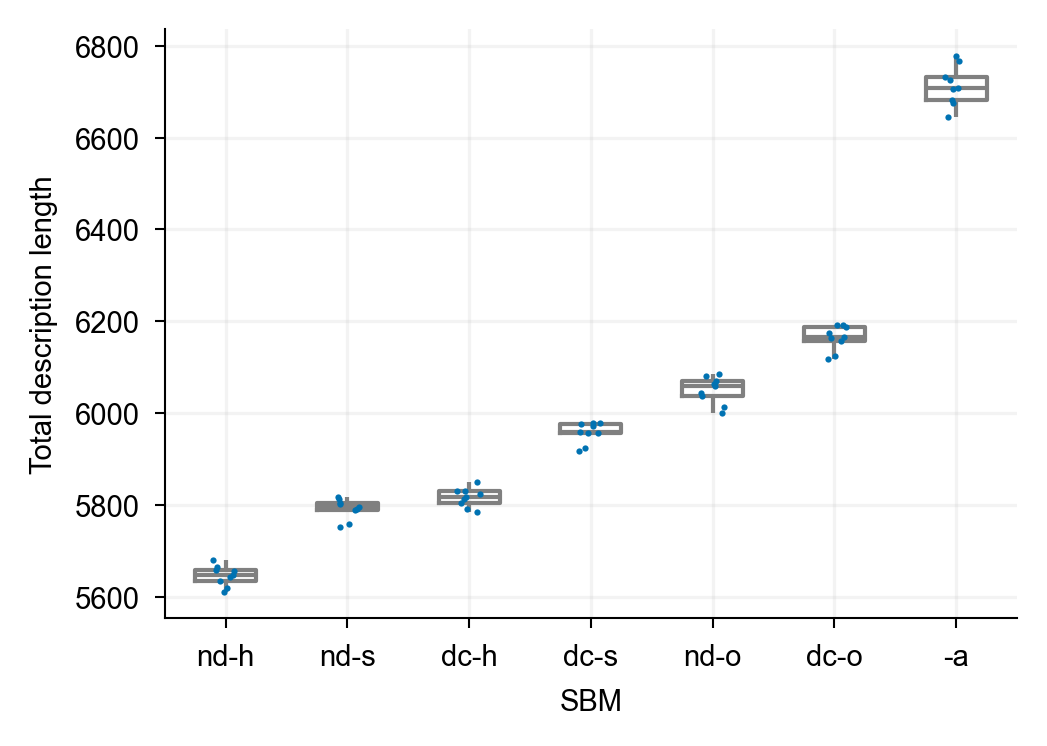

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=300)
fs = 7 # fontsize

sns.boxplot(
    data=long_df,
    x='model',
    y='dl',
    ax=ax,
    fill=None,
    fliersize=0,
    color='grey',
    width=0.5,
    linewidth=1,
    capprops=dict(linewidth=0),
)

sns.stripplot(
    data=long_df,
    x='model', 
    y='dl',
    color=CUD_COLORS[0],
    alpha=1.0,
    ax=ax,
    size=1.5,
    jitter=True,
)

# ax = connect_repeated_measures(long_df, ax)
# ax = annotate_stats(long_df, ax)

# Axis formatting
ax.set_ylabel("Total description length", fontsize=fs)
ax.set_xlabel("SBM", fontsize=fs)
ax.set_title("", fontsize=fs)
ax.tick_params(axis='both', labelsize=fs)
ax.grid(alpha=0.15)
# ax.legend()
sns.despine(ax=ax)
plt.tight_layout()

In [28]:
out_folder = f'{ESTIM_path}/group/model-comparison'
os.system(f'mkdir -p {out_folder}')

with open(f'{out_folder}/desc-evidences.pkl', 'wb') as f:
    pickle.dump(main_df, f)
    
with open(f'{out_folder}/desc-evidences-longform.pkl', 'wb') as f:
    pickle.dump(long_df, f)

with open(f'{out_folder}/desc-comparisons.pkl', 'wb') as f:
    pickle.dump(comps_df, f)

fig.savefig(f'{out_folder}/desc-plot.svg', format='svg', bbox_inches='tight', transparent=True)
fig.savefig(f'{out_folder}/desc-plot.png', format='png', bbox_inches='tight', transparent=True)

---

In [29]:
m = main_df['nd-h'].median()

with open(f'{out_folder}/desc-central-resample.pkl', 'wb') as f:
    pickle.dump(
        main_df[main_df['nd-h'] == m][['sub', 'nd-h']],
        f
    )